# Chapter8 : Generative deep learning

## 8.5 Introduction to generative adversarial networks

Generative adversarial networks (GANs) are an alternative to VAEs for learning latent spaces of images. They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones.

In short, a GAN is: a ***generator network*** and a ***discriminator network***, being trained to best the other. A GAN is made of two parts:
  + *Generator network*--Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image
  + *Discriminator network (or adversary)*--Takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the generator network.
  
**The generator network is trained to be able to fool the discriminator network, and thus it evolves toward generating increasingly realistic images as training goes on**: artificial images that look indistinguishable from real ones, to the extent that it's impossible for the discriminator network to tell the two apart.

Meanwhile, **the discriminator is constantly adapting to the gradually improving capabilities of the generator, setting a high bar of realism for the generated images**. Once training is over, the generator is capable of turning any point in its input space into a believable image. Unlike VAEs, this latent space has fewer explicit guarantees of meaningful structure; in particular, it isn't continuous.

<img src='image/fig815.PNG' width='580'>

Remarkably, a GAN is a system where the optimization minimum isn't fixed, unlike in any other training setup you've encountered in this book.

With GAN, every small step changes the entire landscape a little. It's a dynamic system where the optimization process is seeking not a minimum, but an equilibrium between two forces. For this reason, *GANs are notoriously difficult to train*--getting a GAN to work requires lots of careful tuning of the model architecture and training parameters.

### 8.5.1 A schematic GAN implementation

In this section, we'll explain how to implement a GAN in Keras, in its barest form. The specific implementation is a *deep convolutional GAN (DCGAN)*: a GAN where the generator and discriminator are deep convnets.

You'll train the GAN on images from CIFAR10, a dataset of 50,000 32×32 RGB images belonging to 10 classes (5,000 images per class). To make things easier, you'll only use images belonging to the class "frog".

Schematically, the GAN looks like this:
  1. A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
  2. A `discriminator` network maps images of shape `(32, 32, 3)` to binary score estimating the probability that the image is real.
  3. A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.
  4. You train the discriminator using examples of real and fake images along with "real"/"fake" labels, just as you ttrain any regular image-classification model.
  5. To train the generator, you use the gradients of the generator's weights with regard to the loss of the `gan` model. This means, at every step, you move the weights of the generator in a direction that makes the discriminator more likely to classify as "real" the images decoded by the generator. In other words, you train the generator to fool the discriminator.

### 8.5.2 A bag of tricks

The process of training GANs and tuning GAN implementation is notoriously difficult. There are a number of known tricks you should keep in mind.

Here are a few of the tricks used in the implementation of the GAN generator and discriminator in this section. It isn't an exhaustive list of GAN-related tips; you'll find many more across the GAN literature:
  + We use `tanh` as the last activation in the generator, instead of `sigmoid`, which is more commonly found in other types of models.
  + We sample points from the latent space using a *normal distribution* (Gaussian distribution), not a uniform distribution.
  + Stochasticity is good to induce robustness. Because GAN training results in a dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness in two ways:
    - using dropout in the discriminator
    - adding random noise to the labels for the discriminator
  + Sparse gradients can hinder GAN training: max pooling operations and `ReLU` activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using `LeakyReLU` layer instead of a `ReLU` activation (it similar the ReLU, but it relaxes sparsity constraints by allowing small negative activation values).
  + In generated images, it's common to see checkerboard artifacts caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that's divisible by the stride size whenever we use a strided `Conv2DTranspose` or `Conv2D` in both the generator and the discriminator.
  
<img src='image/fig817.PNG' width='500'>

### 8.5.3 The generator

#### GAN generator network

One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use dropout on both the discriminator and the generator.

Let's develop a `generator` model that turns a vector into a candidate image.

In [1]:
import keras
from keras import layers
import numpy as np

Using TensorFlow backend.


In [0]:
latent_dim = 32
height = 32
width = 32
channels = 3

In [3]:
generator_input = keras.Input(shape=(latent_dim,))

# transforms the input into a 16×16 128-channel feature map
x = layers.Dense(128*16*16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# upsamples to 32×32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# produces a 32×32 1-channel feature map (shape of a CIFAR10 image)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
# instantiates the generator model, 
# which maps the input of shape (latent_dim,) into an image of shape (32,32,3)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

### 8.5.4 The discriminator

#### The GAN discriminator network

Next, you'll develop a `discriminator` model that takes as input a candidate image (real or synthetic) and classifies it into one of two classes: "generated image" or "real image that comes from the training set".

In [4]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# one dropout layer: an important trick!
x = layers.Dropout(0.4)(x)

# instantiates the discriminator model,
# which turns a (32, 32, 3) input into a binary classification decision (fake/real)
# classification layer
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

In [0]:
discriminator_optimizer = keras.optimizers.RMSprop(
     lr=0.0008,
     clipvalue=1.0, # uses gradient clipping (by value) in the optimizer
     decay=1e-8)    # to stabilize training, uses learning-rate decay 
discriminator.compile(optimizer=discriminator_optimizer,
                       loss='binary_crossentropy')

### 8.5.5 The adversarial network

Finally, you'll set up the GAN, which chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its ability to fool the discriminator.

This model turns latent-space points into a classification decision--"fake" or "real"--and it's meant to be trained with labels that are always "these are real images". So training `gan` will update the weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images.

It's very important to note that you **set the discriminator to be frozen during training (non-trainable)**: its weights won't be updated when training `gan`. That is, if the discriminator weights could be updated during this process, then you'd be training the discriminator to always predict "real", which isn't what you want!

#### Adversarial network

In [0]:
# sets discriminator weights to non-trainable
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004,
                                         clipvalue=1.0,
                                         decay=1e-8)
gan.compile(optimizer=gan_optimizer,
            loss='binary_crossentropy')

### 8.5.6 How to train you DCGAN

Now you can begin training. To recapitulate, that is what the training loop looks like schematically. For each epoch, you do the following:
  1. Draw random points in the latent space (random noise).
  2. Generate image with `generator` using this random noise.
  3. Mix the generated images with real ones.
  4. Train `discriminator` using these mixed images, with corresponding targets: either "real" (for the real images) or "fake" (for the generated images).
  5. Draw new random points in the latent space.
  6. Train `gan` using these random vectors, with targets that all say "these are real images". This updates the weights of the generator (only, because the discriminator is frozen inside `gan`) to move them toward getting the discriminator to predict "these are real images" for generated images: this trains the generator to fool the discriminator.

#### Implementing GAN training

In [0]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select dog images (class 5)
x_train = x_train[y_train.flatten() == 5]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [8]:
x_train.shape

(5000, 32, 32, 3)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

In [11]:
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [12]:
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_2 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [13]:
iterations = 10000
batch_size = 20
save_dir = '/content/drive/My Drive/github/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels = labels + 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start = start + batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('/content/drive/My Drive/github/gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_dog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_dog' + str(step) + '.png'))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6882876
adversarial loss at step 0: 0.69443476
discriminator loss at step 100: 0.622578
adversarial loss at step 100: 1.1532059
discriminator loss at step 200: 0.68997896
adversarial loss at step 200: 0.73220384
discriminator loss at step 300: 0.7003889
adversarial loss at step 300: 0.8988147
discriminator loss at step 400: 0.68260145
adversarial loss at step 400: 0.7336546
discriminator loss at step 500: 0.6906723
adversarial loss at step 500: 0.7646166
discriminator loss at step 600: 0.7027854
adversarial loss at step 600: 0.77542514
discriminator loss at step 700: 0.6922204
adversarial loss at step 700: 0.74403155
discriminator loss at step 800: 0.73204744
adversarial loss at step 800: 0.7646332
discriminator loss at step 900: 0.7138254
adversarial loss at step 900: 0.7957219
discriminator loss at step 1000: 0.69800305
adversarial loss at step 1000: 0.73184127
discriminator loss at step 1100: 0.6862015
adversarial loss at step 1100: 0.76755255
discrim

When training, you may see the adversarial loss begin to increase considerably, while the discriminator loss tends to zero--the discriminator may end up dominating the generator.

#### Let's display a few of out fake images

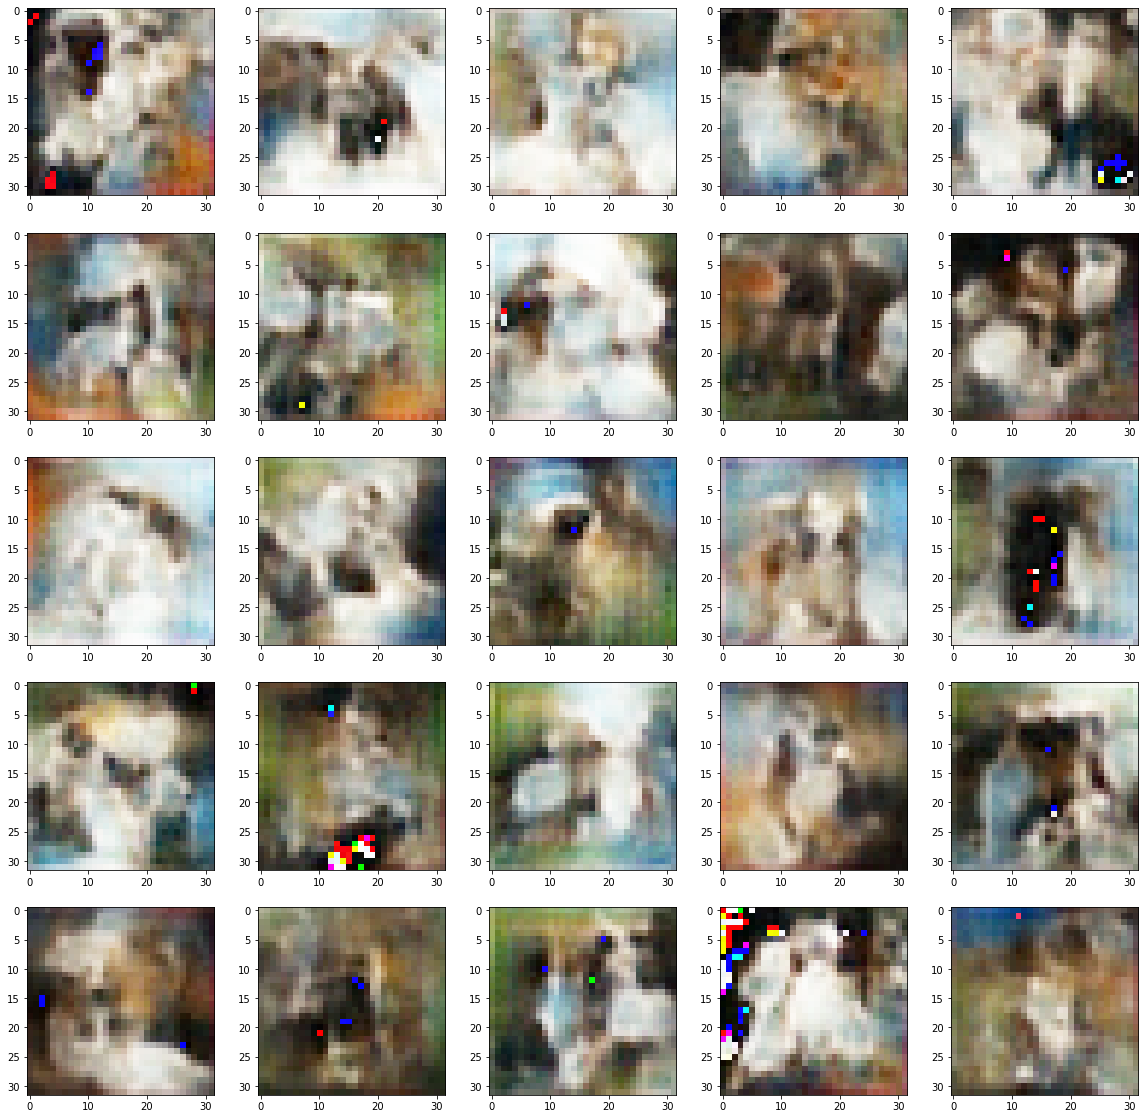

In [30]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(25, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

f, ax = plt.subplots(5, 5, figsize=(20,20))

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    ax[i//5,i%5].imshow(img)
    
plt.show()